In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
from IPython.display import clear_output

FOLDERNAME = "programming/nlp/"
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME


Mounted at /content/drive
/content/drive/My Drive/programming/nlp


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.layers import Conv1D, GlobalMaxPooling1D


In [ ]:
import io

def load_vectors(fname):
    f = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, f.readline().split())
    data = {}
    for line in f:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [ ]:
word_vectors = load_vectors('dataset/tiki_sentiment/word2vec_vi_words_300dims.txt')
word_vectors 

In [ ]:
df = pd.read_csv('dataset/tiki_sentiment/preprocessed_data.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,ttn_gia,ttn_bl_diem,ttn_bl_noi_dung,ttn_thuong_hieu
0,45.000,5,chất lượng sản phẩm tuyệt vời,No Brand
1,255.000,4,"chất lượng sản phẩm tuyệt vời, chất lượng sản ...",No Brand
2,105.000,5,chất lượng sản phẩm tuyệt vời đóng gói sản phẩ...,No Brand
3,180.000,5,"giày đẹp lắm :red_heart: , thời gian giao hàng...",No Brand
4,34.000,4,hsd tới 251 y chang chị mây tư vấn chĩ mây dễ ...,Lotte


In [ ]:
def labelize(sentences, label):
  result = []
  prefix = label
  for i, t in zip(sentences.index, sentences):
      result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
  return result
X = df.ttn_bl_noi_dung
Y = df.ttn_bl_diem

X_w2v = labelize(X, 'all_words')

In [ ]:
cores = multiprocessing.cpu_count()

model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(X_w2v)])
for epoch in range(50):
  model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(X_w2v)]),
                      total_examples=len(X_w2v), epochs=1)
  model_ug_cbow.alpha -= 0.002
  model_ug_cbow.min_alpha = model_ug_cbow.alpha


model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(X_w2v)])
for epoch in range(50):
  model_ug_sg.train(utils.shuffle([x.words for x in tqdm(X_w2v)]),
                      total_examples=len(X_w2v), epochs=1)
  model_ug_sg.alpha -= 0.002
  model_ug_sg.min_alpha = model_ug_sg.alpha

In [ ]:
model_ug_cbow.wv.save('dataset/tiki_sentiment/model_cbow.model')
model_ug_sg.wv.save('dataset/tiki_sentiment/model_sg.model')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
def get_w2v_mean(sentence, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in sentence.split():
      try:
          vec += np.append(model_ug_cbow[word],model_ug_sg[word]).reshape((1, size))
          count += 1.
      except KeyError:
          continue
  if count != 0:
      vec /= count
  return vec

def lr_cv(splits, X, Y, average_method):
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
  accuracy = []
  precision = []
  recall = []
  f1 = []
  for train, test in kfold.split(X, Y):
    X_train_numpy = X[train].to_numpy()
    Y_train_numpy = Y[train].to_numpy()

    X_train_numpy = X_train_numpy.reshape(-1, 1)

    X_train, Y_train  = ros.fit_resample(X_train_numpy, Y_train_numpy)
    X_test = X[test]
    Y_test = Y[test]

    X_train = X_train.reshape(-1)

    train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_train]))
    test_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_test]))

    clf.fit(train_vecs_cbowsg_mean, Y_train)
    prediction = clf.predict(test_vecs_cbowsg_mean)
    scores = clf.score(test_vecs_cbowsg_mean, Y_test)

    accuracy.append(scores * 100)
    precision.append(precision_score(Y[test], prediction, average=average_method)*100)
    print('            1            2            3           4           5')
    print('precision:',precision_score(Y[test], prediction, average=None))
    recall.append(recall_score(Y[test], prediction, average=average_method)*100)
    print('recall:   ',recall_score(Y[test], prediction, average=None))
    f1.append(f1_score(Y[test], prediction, average=average_method)*100)
    print('f1 score: ',f1_score(Y[test], prediction, average=None))
    print('-'*50)

  print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
  print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
  print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
  print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

  ConfusionMatrixDisplay.from_estimator(clf, test_vecs_cbowsg_mean, Y_test)
  plt.show()

In [ ]:
clf = LogisticRegression(multi_class='multinomial')
ros = RandomOverSampler(random_state=42)
lr_cv(5, X, Y, 'macro')

CBOW result:

CBOW concat SKIP-GRAM result:

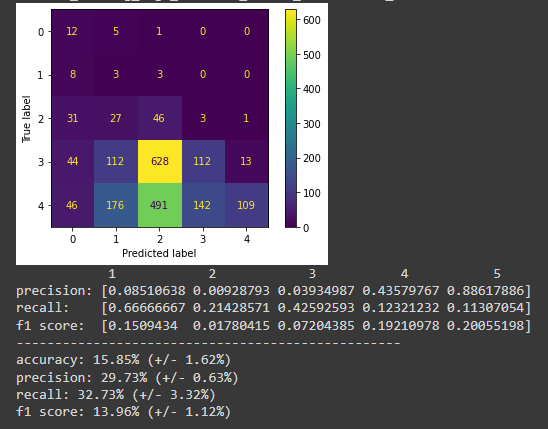

In [ ]:
X = df.ttn_bl_noi_dung
Y = df.ttn_bl_diem - 1
from sklearn.model_selection import train_test_split
SEED = 2000
X_train, X_validation_and_test, Y_train, Y_validation_and_test = train_test_split(X, Y, test_size=.02, random_state=SEED)
X_val, X_test, Y_val, Y_test = train_test_split(X_validation_and_test, Y_validation_and_test, test_size=.5, random_state=SEED)
print("Train set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% slight negative, {3:.2f}% neutral, {4:.2f}% slight positive, {5:.2f}% positive".format(
    len(x_train), 
    (len(x_train[Y_train == 0]) / (len(X_train)*1.))*100, 
    (len(x_train[Y_train == 1]) / (len(X_train)*1.))*100, 
    (len(x_train[Y_train == 2]) / (len(X_train)*1.))*100, 
    (len(x_train[Y_train == 3]) / (len(X_train)*1.))*100, 
    (len(x_train[Y_train == 4]) / (len(X_train)*1.))*100))
print("Validation set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% slight negative, {3:.2f}% neutral, {4:.2f}% slight positive, {5:.2f}% positive".format(
    len(X_val), 
    (len(X_val[y_validation == 0]) / (len(X_val)*1.))*100, 
    (len(X_val[y_validation == 1]) / (len(X_val)*1.))*100, 
    (len(X_val[y_validation == 2]) / (len(X_val)*1.))*100, 
    (len(X_val[y_validation == 3]) / (len(X_val)*1.))*100, 
    (len(X_val[y_validation == 4]) / (len(X_val)*1.))*100))
print("Test set has total {0} entries with \n {1:.2f}% negative, {2:.2f}% slight negative, {3:.2f}% neutral, {4:.2f}% slight positive, {5:.2f}% positive".format(
    len(X_test),
    (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 1]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 2]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 3]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 4]) / (len(X_test)*1.))*100))

Train set has total 9864 entries with 
 0.85% negative, 0.69% slight negative, 5.38% neutral, 45.19% slight positive, 47.88% positive
Validation set has total 101 entries with 
 2.97% negative, 0.00% slight negative, 2.97% neutral, 41.58% slight positive, 52.48% positive
Test set has total 101 entries with 
 1.98% negative, 0.00% slight negative, 5.94% neutral, 45.54% slight positive, 46.53% positive


In [ ]:
# resampling
ros = RandomOverSampler(random_state=42)

X_train = np.expand_dims(X_train, axis=1)
X_train, Y_train  = ros.fit_resample(X_train, Y_train)
X_train = np.squeeze(X_train)

(23615,)

In [ ]:
X_train_numpy, Y_train_numpy = X_train.to_numpy(), Y_train.to_numpy()
Y_val, Y_test = Y_val.to_numpy(), Y_test.to_numpy()

Y_train = np.int32(to_categorical(Y_train))
Y_val = np.int32(to_categorical(Y_val))
Y_test = np.int32(to_categorical(Y_test))

train_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_train]))
val_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_val]))
test_vecs_cbowsg_mean = scale(np.concatenate([get_w2v_mean(z, 200) for z in X_test]))

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
seed = 7
np.random.seed(seed)

filepath="dataset/tiki_sentiment/w2v_01_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint]
# callbacks_list = [checkpoint, early_stop]

model_01 = Sequential()
model_01.add(Dense(256, activation='relu', input_dim=200))
model_01.add(Dense(256, activation='relu'))
model_01.add(Dense(256, activation='relu'))
model_01.add(Dense(5, activation='softmax'))
model_01.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc',f1_m,precision_m, recall_m])

model_01.fit(train_vecs_cbowsg_mean, Y_train, validation_data=(val_vecs_cbowsg_mean, Y_val), 
                 epochs=100, batch_size=32, verbose=2, callbacks=callbacks_list)


Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.31683, saving model to dataset/tiki_sentiment/w2v_01_best_weights.hdf5
738/738 - 3s - loss: 0.4390 - acc: 0.8296 - f1_m: 0.8206 - precision_m: 0.8596 - recall_m: 0.7943 - val_loss: 1.8900 - val_acc: 0.3168 - val_f1_m: 0.3397 - val_precision_m: 0.3515 - val_recall_m: 0.3297 - 3s/epoch - 4ms/step
Epoch 2/100

Epoch 00002: val_acc improved from 0.31683 to 0.41584, saving model to dataset/tiki_sentiment/w2v_01_best_weights.hdf5
738/738 - 2s - loss: 0.2686 - acc: 0.8943 - f1_m: 0.8938 - precision_m: 0.9015 - recall_m: 0.8866 - val_loss: 1.4825 - val_acc: 0.4158 - val_f1_m: 0.4607 - val_precision_m: 0.5059 - val_recall_m: 0.4234 - 2s/epoch - 3ms/step
Epoch 3/100

Epoch 00003: val_acc did not improve from 0.41584
738/738 - 2s - loss: 0.2204 - acc: 0.9087 - f1_m: 0.9083 - precision_m: 0.9128 - recall_m: 0.9041 - val_loss: 2.3203 - val_acc: 0.3564 - val_f1_m: 0.3785 - val_precision_m: 0.3891 - val_recall_m: 0.3688 - 2s/epoch - 3ms/step
E

In [ ]:
model_01.save('dataset/tiki_sentiment/w2v_neural_network.h5')

In [ ]:
loss, accuracy, f1_score, precision, recall = model_01.evaluate(test_vecs_cbowsg_mean, Y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)

4/4 - 0s - loss: 3.5364 - acc: 0.4554 - f1_m: 0.4831 - precision_m: 0.4884 - recall_m: 0.4781 - 20ms/epoch - 5ms/step
Test accuracy:  45.54455578327179


In [ ]:
Y_pred = model_01.predict(test_vecs_cbowsg_mean)
Y_pred = Y_pred.argmax(axis=1)
print(confusion_matrix(Y_pred, Y_test))

[[ 0  0  0  3  3]
 [ 0  0  0  1  0]
 [ 1  0  6 11 14]
 [ 1  0  0 25 10]
 [ 0  0  0  6 20]]


In [ ]:
sentence = 'cái áo này đẹp'
sentence_vector = get_w2v_mean(sentence, 200)
prediction = model_01.predict(sentence_vector).argmax(axis=1)
print(prediction)

[3]


CBOW/SKIP-GRAM + Neural network 

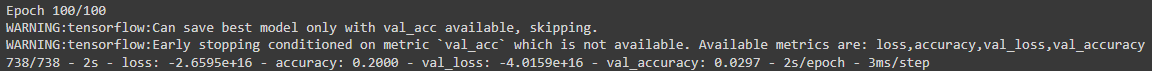

accuracy: 20%

In [ ]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('dataset/tiki_sentiment/model_cbow.model')
model_ug_sg = KeyedVectors.load('dataset/tiki_sentiment/model_sg.model')


In [ ]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
clear_output()

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=100000)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=45)
X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=45)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=45)

In [ ]:
tokenizer.word_index.items()

dict_items([('sản', 1), ('phẩm', 2), ('rất', 3), ('chất', 4), ('lượng', 5), ('tuyệt', 6), ('vời', 7), ('đẹp', 8), ('gói', 9), ('và', 10), ('đóng', 11), ('hàng', 12), ('shop', 13), ('chắc', 14), ('chắn', 15), ('giao', 16), ('tiền', 17), ('tốt', 18), ('nhanh', 19), ('gian', 20), ('thời', 21), ('đáng', 22), ('vụ', 23), ('phục', 24), ('áo', 25), ('kém', 26), ('không', 27), ('được', 28), ('ko', 29), ('vải', 30), ('hình', 31), ('nhưng', 32), ('k', 33), ('có', 34), ('tạm', 35), ('như', 36), ('màu', 37), ('mua', 38), ('quá', 39), ('mặc', 40), ('mình', 41), ('hơi', 42), ('face', 43), ('mà', 44), ('thì', 45), ('giá', 46), ('với', 47), ('giống', 48), ('là', 49), ('cho', 50), ('ok', 51), ('bị', 52), ('lắm', 53), ('mỏng', 54), ('1', 55), ('lại', 56), ('nên', 57), ('size', 58), ('heart', 59), ('nhận', 60), ('đặt', 61), ('cũng', 62), ('quần', 63), ('with', 64), ('đc', 65), ('của', 66), ('cái', 67), ('luôn', 68), ('này', 69), ('xấu', 70), ('ạ', 71), ('smiling', 72), ('chỉ', 73), ('dài', 74), ('sẽ', 75

In [ ]:
num_words = len(X_train)
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
Y_train, Y_val, Y_test = Y_train.to_numpy(), Y_val.to_numpy(), Y_test.to_numpy()

Y_train = np.int32(to_categorical(Y_train))
Y_val = np.int32(to_categorical(Y_val))
Y_test = np.int32(to_categorical(Y_test))

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
seed = 7
np.random.seed(seed)

filepath="dataset/tiki_sentiment/w2v_02_best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
callbacks_list = [checkpoint]

model_02 = Sequential()
e = Embedding(num_words, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_02.add(e)
model_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_02.add(GlobalMaxPooling1D())
model_02.add(Dense(256, activation='relu'))
model_02.add(Dense(5, activation='softmax'))
model_02.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_02.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=32, verbose=2)


Epoch 1/10
309/309 - 15s - loss: 0.7548 - accuracy: 0.6601 - val_loss: 0.6338 - val_accuracy: 0.6832 - 15s/epoch - 50ms/step
Epoch 2/10
309/309 - 15s - loss: 0.6264 - accuracy: 0.7054 - val_loss: 0.6316 - val_accuracy: 0.7129 - 15s/epoch - 47ms/step
Epoch 3/10
309/309 - 15s - loss: 0.5514 - accuracy: 0.7404 - val_loss: 0.5753 - val_accuracy: 0.6634 - 15s/epoch - 47ms/step
Epoch 4/10
309/309 - 15s - loss: 0.4840 - accuracy: 0.7748 - val_loss: 0.5893 - val_accuracy: 0.6931 - 15s/epoch - 47ms/step
Epoch 5/10
309/309 - 15s - loss: 0.4034 - accuracy: 0.8141 - val_loss: 0.6532 - val_accuracy: 0.6535 - 15s/epoch - 47ms/step
Epoch 6/10
309/309 - 15s - loss: 0.3476 - accuracy: 0.8360 - val_loss: 0.8225 - val_accuracy: 0.6436 - 15s/epoch - 47ms/step
Epoch 7/10
309/309 - 14s - loss: 0.3010 - accuracy: 0.8591 - val_loss: 0.8639 - val_accuracy: 0.6535 - 14s/epoch - 47ms/step
Epoch 8/10
309/309 - 14s - loss: 0.2662 - accuracy: 0.8723 - val_loss: 0.9497 - val_accuracy: 0.6634 - 14s/epoch - 47ms/step


In [ ]:
model_02.save('dataset/tiki_sentiment/w2v_cnn.h5')

In [ ]:
loss, accuracy, f1_score, precision, recall = model_02.evaluate(X_test, Y_test, batch_size=32, verbose=2)
print('Test accuracy: ',accuracy * 100)

In [ ]:
Y_pred = model_02.predict(X_test)
Y_pred = Y_pred.argmax(axis=1)
print(confusion_matrix(Y_pred, Y_test))